In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

https://www.tandfonline.com/doi/abs/10.1080/15481603.2014.939539
https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681

# Urbanisation

** ADD description

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [3]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.import_export import export_xarray_to_multiple_geotiffs



In [4]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

## Set Variables

In [5]:
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "LANDSAT_7"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (30)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '1999-1-1'
baseline_end_date = '2002-12-1'

#set the analysis start and end of period
#analysis_start_date = '2017-1-1'
#analysis_end_date = '2017-12-1'

# If a geomedian is selected, it will take much longer to process

# options are "median" or "geomedian"
#mosaic_type = "geomedian" # change this to geomedian 

#define AOI
#central area - do dates 2013- 2014 and 2018-2019
#aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
#ai_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON((179.4389622562436 -16.668794626017938,179.51758316688813 -16.668794626017938,179.51758316688813 -16.734562495004166,179.4389622562436 -16.734562495004166,179.4389622562436 -16.668794626017938))"
#aoi_wkt = "POLYGON((179.34386185341157 -16.511847130448928,179.73662308388032 -16.511847130448928,179.73662308388032 -16.83810084556268,179.34386185341157 -16.83810084556268,179.34386185341157 -16.511847130448928))"
aoi_wkt = "POLYGON((178.39699689321165 -18.061332095979633,178.55080548696165 -18.061332095979633,178.55080548696165 -18.18467000208122,178.39699689321165 -18.18467000208122,178.39699689321165 -18.061332095979633))"

## create AOI

In [6]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [7]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [8]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [9]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [10]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [11]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [12]:
print(lat_range)

(3868865.296636806, 3882539.0512192366)


In [13]:
print(lon_range)

(1962643.4711290102, 1978898.4636792026)


## Translate inputs and load data

In [14]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements
        product = 'ls7_geomedian_annual'
        #water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product

In [15]:
baseline_product = create_product_measurement(platform_base)

In [16]:
#create resolution
resolution = (-res, res)

In [17]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [18]:
print(lat_range)

(3868865.296636806, 3882539.0512192366)


In [19]:
print(lon_range)

(1962643.4711290102, 1978898.4636792026)


In [20]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)

In [21]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks
}


In [22]:
baseline_ds = dc.load(
    time = baseline_time_period,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)


> #### Check if loads are valid

In [23]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [24]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [25]:
print(baseline_ds)

<xarray.Dataset>
Dimensions:  (time: 4, x: 543, y: 456)
Coordinates:
  * time     (time) datetime64[ns] 1999-07-02 2000-07-01T12:00:00 ... 2002-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    blue     (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    green    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460


baseline_ds[['red','green','blue']].to_array().plot.imshow(
    x=baseline_ds.crs.dimensions[1],
    y=baseline_ds.crs.dimensions[0],
    col='time',
    #figsize=(20, 20),
    vmin=0,
    vmax=3000,
    col_wrap=4,
    #add_colorbar=False
)

## Calculate NDBI

In [26]:
from datacube_utilities.createindices import NDVI, NDWI, NDBI

In [27]:
#ndbi_base = NDBI(baseline_ds_2)  # Urbanization

In [28]:
def NDBI(dataset):
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [29]:
def MNDWI(dataset):
    return (dataset.green - dataset.swir2)/(dataset.green + dataset.swir2)

In [30]:
mndwi_base = MNDWI(baseline_ds)

In [31]:
ndbi_base = NDBI(baseline_ds)

In [32]:
ndvi_base = NDVI(baseline_ds)

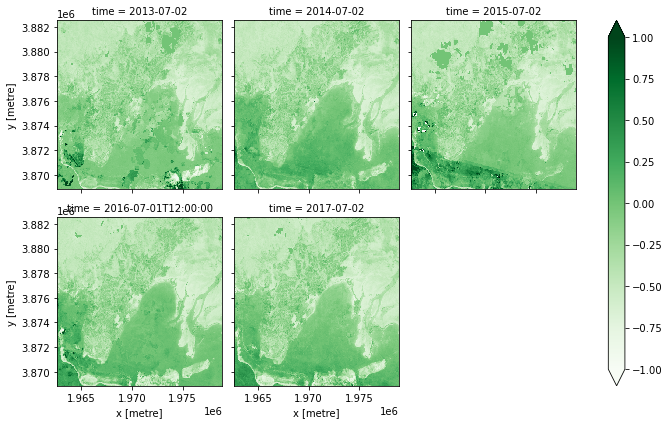

In [33]:
ndbi_base.plot(col='time', cmap='Greens', col_wrap=3, vmin =-1, vmax = 1)

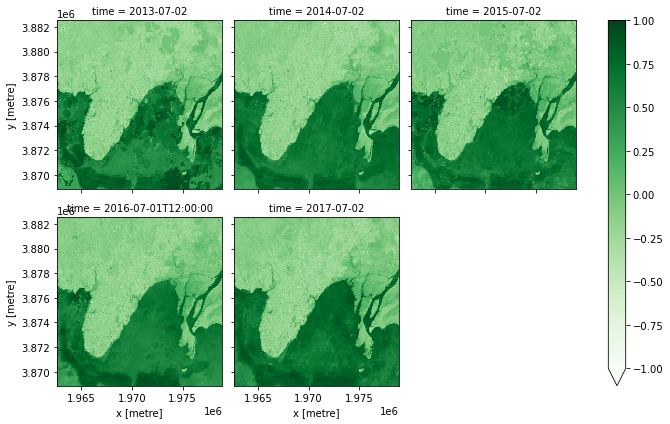

In [34]:
mndwi_base.plot(col='time', cmap='Greens', col_wrap=3, vmin =-1, vmax = 1)

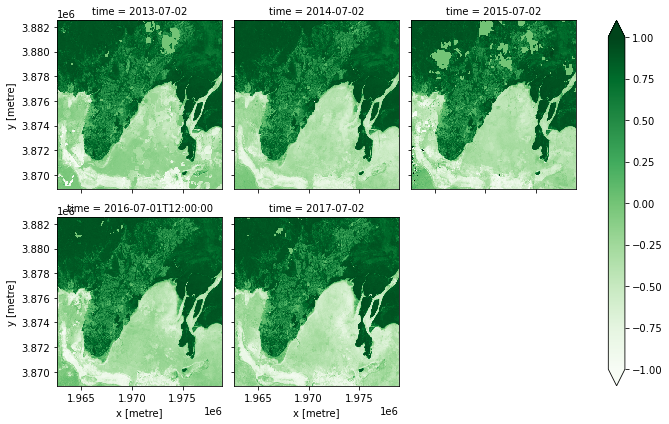

In [35]:
ndvi_base.plot(col='time', cmap='Greens', col_wrap=3, vmin =-1, vmax = 1)

In [36]:
#ndvi_base = NDVI(baseline_ds)  # Urbanization

In [37]:
BU_index1 = (ndbi_base) - (ndvi_base) - (mndwi_base)
#BU_index1 = ndbi_base - ndvi_base

In [38]:
BU_index1.plot(col='time', cmap='Greens', col_wrap=3, vmin =-1.5, vmax = 1)

KeyboardInterrupt: 

In [ ]:
#BU_index = BU_index1

In [ ]:
print(ndbi_base.time.dt.year)

In [ ]:
#ndbi_base.time = ndbi_base.time.dt.year

In [ ]:
BU_index = BU_index1.compute()

In [ ]:
BU_index = xr.DataArray.to_dataset(BU_index, name = 'ndbi')

In [ ]:
###EXPORT
#write_geotiff_from_xr('test.tiff', ndbi_ds, crs=output_projection, x_coord = 'x', y_coord = 'y')
export_xarray_to_multiple_geotiffs(BU_index, 'urban_out/annual', x_coord='x', y_coord='y')

## Shapefile

In [ ]:
#import required modules
import geopandas
import matplotlib.pyplot as plt
import os, gc, glob
import rasterstats as rs
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:

#inputShp = "/home/s1333131/dissertation/shapefiles/all_bufer_20/outline-buffer/all_together.shp"
#inputShp = "urbanisation/Urban_suva.shp"
#inputShp = "urbanisation/clip_OSM_SUVA.shp"
inputShp = "urbanisation/split_10000_p.shp"
#inputShp = "urbanisation/split_50000.shp"

path = "urban_out/"
#odc-hub/devenvironment/urban_out/annaul_2013_07_02_00_00_00.tif
#put shapefile into a geodataframe
geodf = gpd.read_file(inputShp)
#display polygons
geodf.boundary.plot(color='blue',edgecolor='k',linewidth = 2) #Use your second dataframe

#geodf = geodf.drop(columns=['name', 'landuse'])
#print(geodf)
dataGDF = gpd.GeoDataFrame(geodf)

#get each file from the directory
for folder in os.listdir(path):
        fileSafe = path + folder
        base = os.path.basename(fileSafe)
        base2 = os.path.splitext(base)[0]
        timestamp = base2.split("_")[1]
        if base2 in ".ipynb_checkpoints":
            print("invalid file")
        else:
            geodf2 = geodf
            #calculate statistics from the raster for each shapefile
            createData = rs.zonal_stats(geodf2, fileSafe, prefix=timestamp + '_', stats= 'mean', geojson_out=True)  
            #create a geodataframe of the statistics.
            zonalGDF2 = GeoDataFrame.from_features(createData)
            #append zonal statistics to the shapefile geodataframe
            dataGDF = zonalGDF2.append(dataGDF,sort=True)
            dataGDFnew = dataGDF.groupby(dataGDF.index).max()
            dataGDFn = gpd.GeoDataFrame(dataGDFnew)
#print(dataGDFn)

In [194]:
#bring together the zonal stats and the original polygons
df3 = pd.merge(geodf, dataGDFn, on='FID')
#print(df3)
#set the index as id
df4 = df3.set_index('FID')
#print(df4)
#remove geometry column to allow flipping
df5 = df4.drop('geometry', axis=1)
print(df5)

     1999_mean  2000_mean  2001_mean  2002_mean  2013_mean  2014_mean  \
FID                                                                     
0    -1.001211  -1.151262  -0.968425  -0.970051  -0.451435  -0.310067   
1    -0.616154  -0.849822  -0.688002  -0.613851  -0.614493  -0.667673   
2    -1.139281  -1.224439  -1.101555  -1.013115  -0.881815  -0.772294   
3    -0.926019  -1.034679  -0.850352  -1.010450  -0.414729  -0.296674   
4    -0.963373  -1.052448  -0.917560  -1.171710  -0.701119  -0.647459   
..         ...        ...        ...        ...        ...        ...   
133  -0.618303  -0.681328  -0.792116  -0.595036  -0.505411  -0.343081   
134  -0.690295  -0.735327  -0.826017  -0.636683  -0.745189  -0.629737   
135  -0.776540  -0.781045  -0.775101  -0.674201  -0.758006  -0.748207   
136  -0.829225  -0.864224  -0.920705  -0.701025  -0.649583  -0.634407   
137  -0.839864  -0.914737  -0.858384  -0.718641  -0.790016  -0.804926   

     2016_mean  2017_mean  2018_mean  2019_mean  


In [195]:
df5a = df5.rename(lambda x: x[:4], axis=1)

In [196]:
#create a difference column between two time periods.
df5a['diff'] = df5a['2018'] - df5a['2000']
#set a threshold of change interested in
#print(df5)

In [197]:
#set a threshold of change interested in if needed
df5a = df5a.loc[df5a['diff'] > 0.2 ]
#print(df5)

In [198]:
df6 = df5a.T
df7 = df6.drop('diff')
df7.index = pd.to_datetime(df7.index)
df9 = pd.DataFrame(df7)
#print(df9)

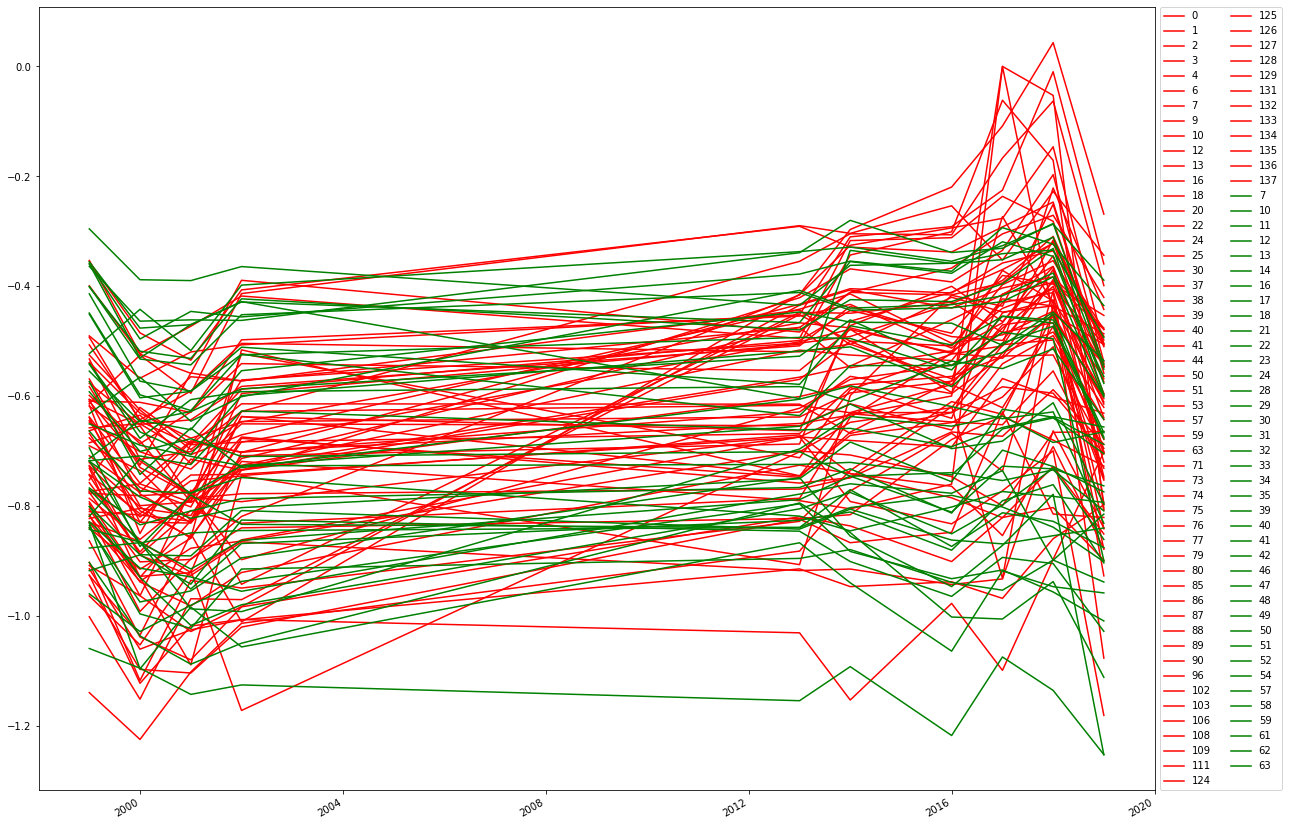

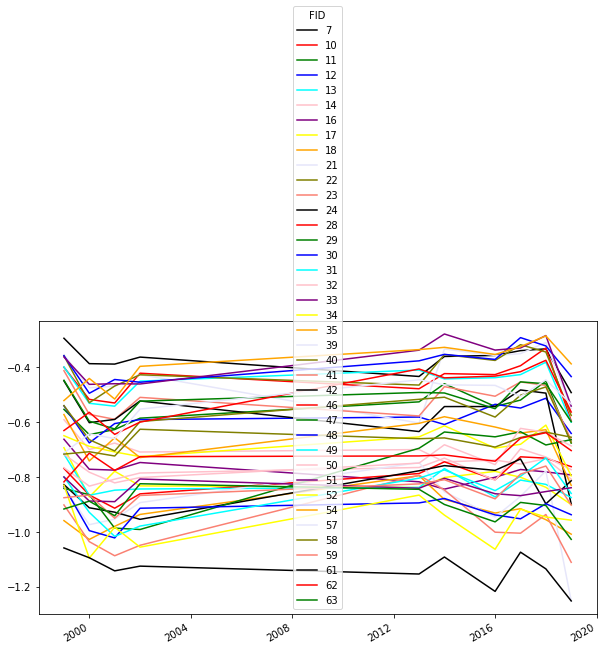

In [199]:
from matplotlib.colors import hsv_to_rgb

fig, ax = plt.subplots(figsize = (20,16)) 
df9.plot(color='red', ax = ax).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

#plt.figure(figsize = (20,20))
colors = [hsv_to_rgb([(i * 0.618033988749895) % 1.0, 1, 1])
          for i in range(1000)]
df8.plot(color='green', ax = ax).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
df8.plot(color=['black', 'red', 'green', 'blue', 'cyan', 'pink', 'purple',  'yellow', 'orange', 'lavender', 'olive', 'salmon'], figsize=(10,6), legend='right')

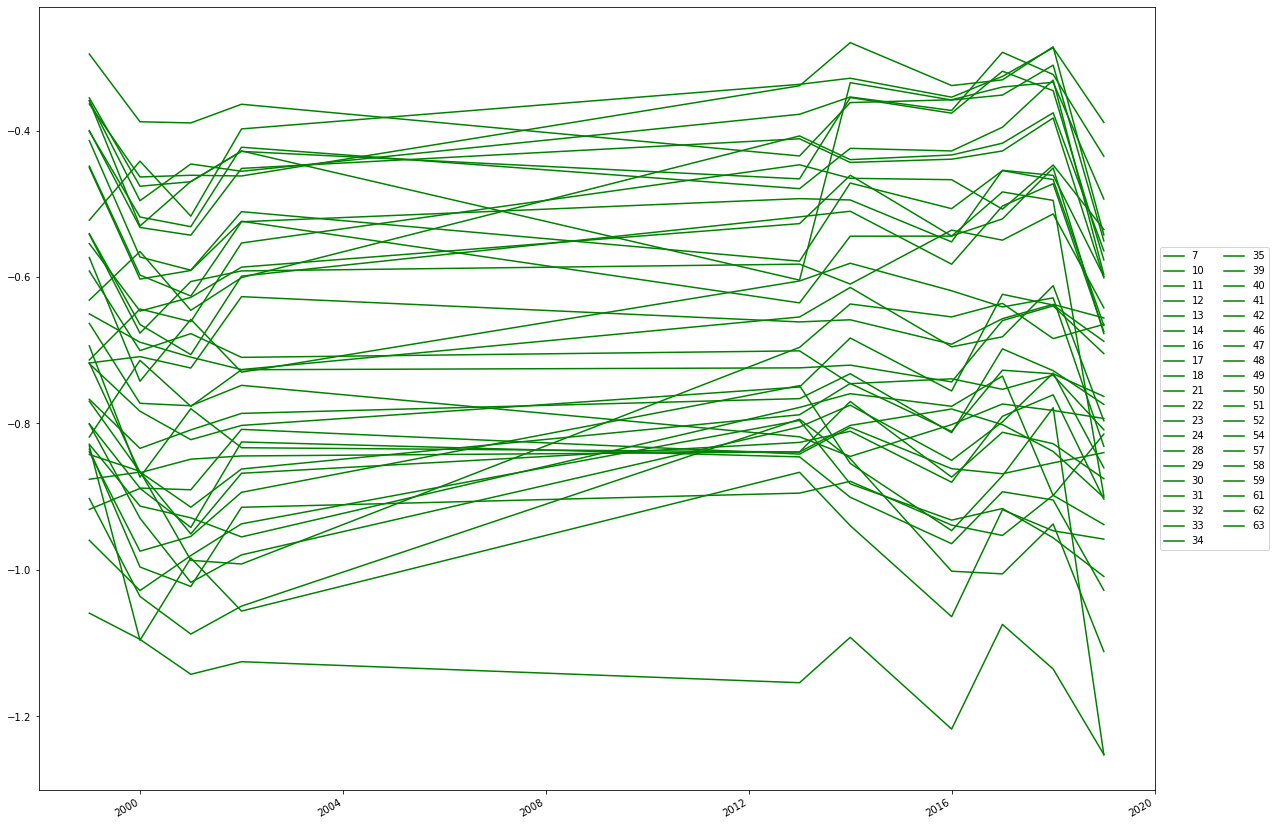

In [200]:
fig, ax = plt.subplots(figsize = (20,16)) 
df8.plot(color='green', ax = ax).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

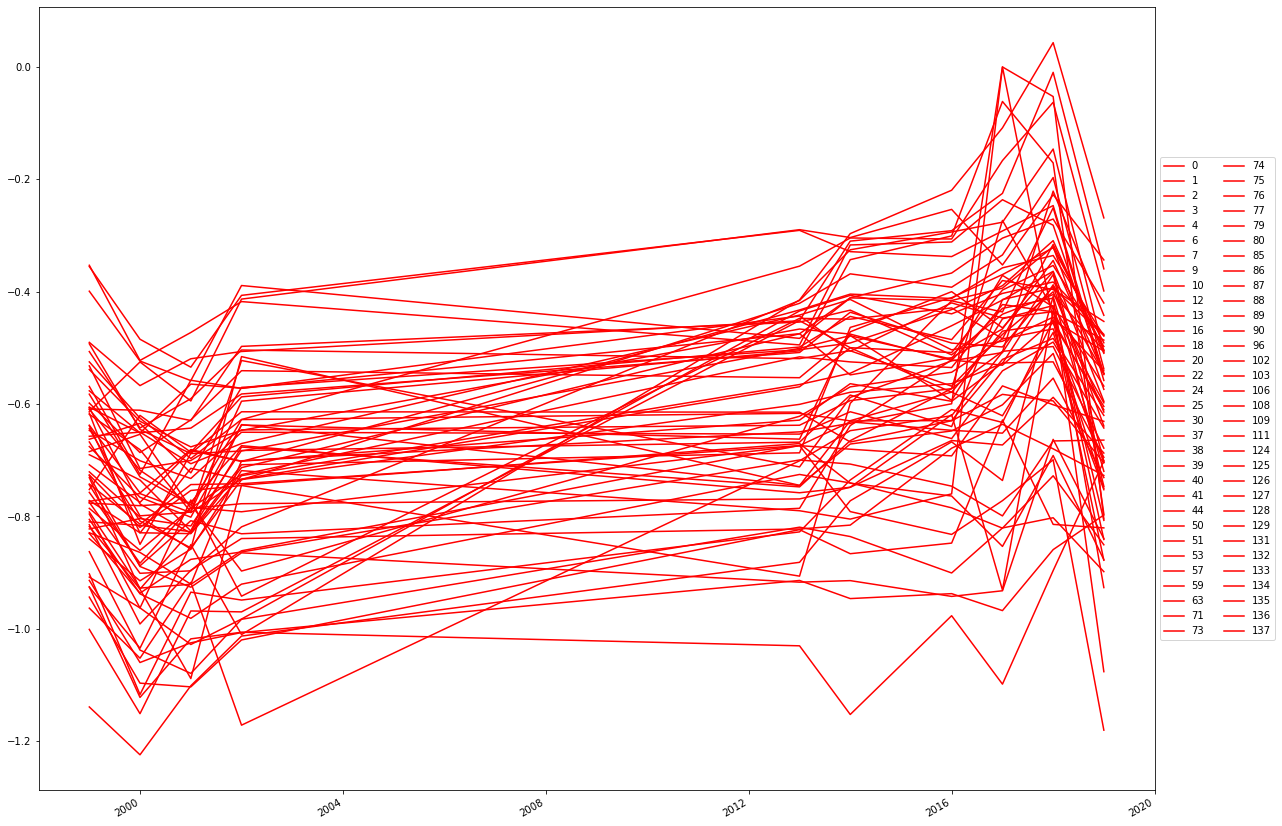

In [201]:
fig, ax = plt.subplots(figsize = (20,16)) 
df9.plot(color='red', ax = ax).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

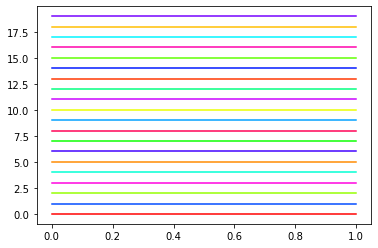

In [202]:
from matplotlib import pyplot as plt

from cycler import cycler

# 1000 distinct colors:

plt.rc('axes', prop_cycle=(cycler('color', colors)))

for i in range(20):
    plt.plot([1, 0], [i, i])

plt.show()